## 교차검증

In [55]:
import numpy as np
from sklearn.model_selection import KFold

X = np.array([[1, 2], [3, 4], [5, 6], [7, 8]]) # 중복 없는 데이터
y = np.array([1, 2, 3, 4])
kf = KFold(n_splits=2, shuffle=False)

print("=== KFold(n_splits=2) 동작 원리 ===")
print(f"전체 데이터 개수: {len(X)}")
print(f"각 fold의 크기: {len(X)//2}")
print()

for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
    print(f"--- Fold {fold} ---")
    print(f"Train 인덱스: {train_idx}")
    print(f"Test 인덱스: {test_idx}")
    print(f"Train 데이터: {X[train_idx].tolist()}")
    print(f"Test 데이터: {X[test_idx].tolist()}")
    print()

=== KFold(n_splits=2) 동작 원리 ===
전체 데이터 개수: 4
각 fold의 크기: 2

--- Fold 1 ---
Train 인덱스: [2 3]
Test 인덱스: [0 1]
Train 데이터: [[5, 6], [7, 8]]
Test 데이터: [[1, 2], [3, 4]]

--- Fold 2 ---
Train 인덱스: [0 1]
Test 인덱스: [2 3]
Train 데이터: [[1, 2], [3, 4]]
Test 데이터: [[5, 6], [7, 8]]



### 와인 맛 분류하던 데이터

In [56]:
import pandas as pd

# 데이터가 저장된 깃허브 URL (레드/화이트 따로)
red_url = "https://github.com/PinkWink/ML_tutorial/raw/refs/heads" + \
          "/master/dataset/winequality-red.csv"
white_url = "https://github.com/PinkWink/ML_tutorial/raw/refs/heads" + \
            "/master/dataset/winequality-white.csv"

# 세미콜론 구분자로 CSV 읽기
red_wine = pd.read_csv(red_url, sep=';')
white_wine = pd.read_csv(white_url, sep=';')

# 와인 색상 정보를 숫자 라벨로 추가
red_wine['color'] = 1.
white_wine['color'] = 0.

# 두 데이터를 하나의 데이터프레임으로 합치기
wine = pd.concat([red_wine, white_wine])

In [57]:
# 품질 점수가 5 이상이면 1(맛있다), 아니면 0(맛없다)로 이진 라벨 생성
wine['taste'] = [1. if grade > 5 else 0. for grade in wine['quality']]

# 입력 특징: 정답 컬럼인 'quality', 'taste'를 제외한 나머지 특성만 사용
X = wine.drop(['quality', 'taste'], axis=1)

# 정답 라벨: 방금 만든 이진 맛 지표
y = wine['taste']

### 의사 결정 나무 모델

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# 훈련/검증 세트를 80:20으로 나눈다(재현성을 위해 random_state 고정)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=13
)

# 깊이를 제한한 결정트리 모델을 만들고 학습시킨다
wine_tree = DecisionTreeClassifier(max_depth=2, random_state =13)
wine_tree.fit(X_train, y_train)

# 훈련/검증 세트 각각에 대한 예측값을 구한다
y_pred_tr = wine_tree.predict(X_train)
y_pred_test = wine_tree.predict(X_test)

# 정확도를 계산해 학습 성능과 일반화 성능을 비교한다
print("Train Acc : ", accuracy_score(y_train, y_pred_tr))
print("Test Acc : ", accuracy_score(y_test, y_pred_test))


Train Acc :  0.7294593034442948
Test Acc :  0.7161538461538461


### KFold

In [59]:
from sklearn.model_selection import KFold

# 단순 K-Fold(계층 아님)로 5개 폴드 생성, 셔플 후 seed 고정
folds = KFold(n_splits=5, shuffle=True, random_state=13)

wine_tree = DecisionTreeClassifier(max_depth=2, random_state=13)

# 각 폴드에서 훈련/검증 인덱스 길이가 어떻게 나뉘는지 출력
for train_idx, test_idx in folds.split(X):
    print(len(train_idx), len(test_idx))


5197 1300
5197 1300
5198 1299
5198 1299
5198 1299


In [60]:
cv_accuracies = []

for fold, (train_idx, test_idx) in enumerate(folds.split(X), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    wine_tree.fit(X_train, y_train)
    y_pred = wine_tree.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    cv_accuracies.append(acc)
    print(f"Fold {fold} Accuracy: {acc}")

Fold 1 Accuracy: 0.7161538461538461
Fold 2 Accuracy: 0.7146153846153847
Fold 3 Accuracy: 0.7228637413394919
Fold 4 Accuracy: 0.7236335642802155
Fold 5 Accuracy: 0.7274826789838337


### 각 acc의 분산이 크지 않다면 평균을 대표 값으로 한다

In [61]:
np.mean(cv_accuracies)

np.float64(0.7209498430745545)

## StratifiedKFold

In [62]:
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# 클래스 비율을 유지한 5-fold 교차검증 객체와 결정트리 모델 준비
skfold = StratifiedKFold(n_splits=5)
wine_tree_cv = DecisionTreeClassifier(max_depth=2, random_state=13)

cv_accuracy = []  # 각 폴드 정확도를 담을 리스트

# StratifiedKFold가 돌려주는 인덱스로 훈련/검증 세트를 나누고 성능을 측정
for train_idx, test_idx in skfold.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    wine_tree_cv.fit(X_train, y_train)
    pred = wine_tree_cv.predict(X_test)
    cv_accuracy.append(accuracy_score(y_test, pred))

cv_accuracy  # 폴드별 정확도 확인

[0.5523076923076923,
 0.6884615384615385,
 0.7143956889915319,
 0.7321016166281755,
 0.7567359507313318]

In [63]:
np.mean(cv_accuracy)

np.float64(0.6888004974240539)

## cross validation

In [64]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
from sklearn.tree import DecisionTreeClassifier

# 클래스 비율을 유지한 5-fold 교차검증 분할자
skfold = StratifiedKFold(n_splits=5)

# 1) 깊이 2의 결정트리로 교차검증 정확도 확인
wine_tree_cv = DecisionTreeClassifier(max_depth=2, random_state=13)

# 데이터 전체(X, y)를 여러 폴드로 나눠 모델을 반복 학습/평가하고, 각 폴드에서 나온 검증 정확도를 배열로 돌려준다
cross_val_score(wine_tree_cv, X, y, scoring=None, cv=skfold)
# → 폴드별 검증 정확도 배열 반환

array([0.55230769, 0.68846154, 0.71439569, 0.73210162, 0.75673595])

### depth가 높다고 무조건 acc가 좋아지는 것도 아니다

In [65]:
# 2) 모델의 복잡도를 높여(depth=5) 동일한 절차 수행
wine_tree_cv = DecisionTreeClassifier(max_depth=5, random_state=13)
cross_val_score(wine_tree_cv, X, y, scoring=None, cv=skfold)
# → 깊이가 늘어났을 때의 폴드별 정확도

array([0.50076923, 0.62615385, 0.69745958, 0.7582756 , 0.74903772])

In [66]:
# 3) 학습/검증 정확도 모두 보고 싶을 때 cross_validate 사용
cross_validate(
    wine_tree_cv,          # 위에서 정의한 모델
    X, y,                  # 전체 데이터/라벨
    scoring=None,          # 기본 점수(accuracy)
    cv=skfold,             # 동일한 StratifiedKFold 사용
    return_train_score=True  # 훈련 세트 점수도 함께 반환
)
# → fit_time/score_time과 train/test score가 담긴 딕셔너리

{'fit_time': array([0.01310301, 0.01398039, 0.01304388, 0.01493049, 0.01330638]),
 'score_time': array([0.00163436, 0.00183797, 0.00151825, 0.00166488, 0.00172877]),
 'test_score': array([0.50076923, 0.62615385, 0.69745958, 0.7582756 , 0.74903772]),
 'train_score': array([0.78795459, 0.78045026, 0.77568295, 0.76356291, 0.76279338])}

## 하이퍼파라미터 튜닝

In [67]:
import pandas as pd

# 공개 깃허브에서 레드/화이트 와인 품질 CSV의 다운로드 URL
red_url = (
    "https://github.com/PinkWink/ML_tutorial/raw/refs/heads"
    + "/master/dataset/winequality-red.csv"
)
white_url = (
    "https://github.com/PinkWink/ML_tutorial/raw/refs/heads"
    + "/master/dataset/winequality-white.csv"
)

# 세미콜론으로 구분된 CSV 읽기
red_wine = pd.read_csv(red_url, sep=";")
white_wine = pd.read_csv(white_url, sep=";")

# 색상 정보를 숫자로 라벨링(붉은색=1, 화이트=0)
red_wine["color"] = 1.0
white_wine["color"] = 0.0

# 두 데이터를 합치고, 품질 점수 5 초과 여부로 맛(taste) 이진 라벨 생성
wine = pd.concat([red_wine, white_wine])
wine["taste"] = [1.0 if grade > 5 else 0.0 for grade in wine["quality"]]

# 학습용 특징(X)과 목표 라벨(y) 분리
X = wine.drop(["taste", "quality"], axis=1)
y = wine["taste"]

In [68]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# 튜닝할 하이퍼파라미터 후보: 결정트리의 최대 깊이``
params = {"max_depth": [2, 4, 7, 10]}
wine_tree = DecisionTreeClassifier(max_depth=2, random_state=13)

# 5-fold 교차검증으로 각 깊이를 평가해 최적 조합을 찾는다
gridsearch = GridSearchCV(estimator=wine_tree, param_grid=params, cv=5)
gridsearch.fit(X, y)  # 탐색 수행 후 best_estimator_ 등 결과 확인 가능

,estimator,DecisionTreeC...ndom_state=13)
,param_grid,"{'max_depth': [2, 4, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [69]:
import pprint

# 그리드 서치 결과를 보기 좋게 출력
pprint.pprint(gridsearch.cv_results_)

{'mean_fit_time': array([0.00739484, 0.01063495, 0.01920738, 0.02538795]),
 'mean_score_time': array([0.00204062, 0.00185361, 0.00191989, 0.00226955]),
 'mean_test_score': array([0.6888005 , 0.66356523, 0.65340854, 0.64401587]),
 'param_max_depth': masked_array(data=[2, 4, 7, 10],
             mask=[False, False, False, False],
       fill_value=999999),
 'params': [{'max_depth': 2},
            {'max_depth': 4},
            {'max_depth': 7},
            {'max_depth': 10}],
 'rank_test_score': array([1, 2, 3, 4], dtype=int32),
 'split0_test_score': array([0.55230769, 0.51230769, 0.50846154, 0.51615385]),
 'split1_test_score': array([0.68846154, 0.63153846, 0.60307692, 0.60076923]),
 'split2_test_score': array([0.71439569, 0.72363356, 0.68360277, 0.66743649]),
 'split3_test_score': array([0.73210162, 0.73210162, 0.73672055, 0.71054657]),
 'split4_test_score': array([0.75673595, 0.7182448 , 0.73518091, 0.72517321]),
 'std_fit_time': array([0.00048983, 0.00054309, 0.00065388, 0.00134037])

In [70]:
gridsearch.best_params_  # 최적 하이퍼파라미터 조합

{'max_depth': 2}

In [71]:
gridsearch.best_estimator_  # 최적 하이퍼파라미터로 학습된 모델

,criterion,'gini'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,13
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [72]:
gridsearch.best_score_ 

np.float64(0.6888004974240539)

### pipeline을 적용한 모델에 GridSearch를 적용하고 싶다면

StandardScaler()는 전처리기야. 각 특징을 평균 0, 표준편차 1이 되도록 표준화(z-score 정규화)해서 모델이 특정 스케일에 치우치지 않도록 해 준다

In [73]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

# (이름, 단계) 튜플 리스트로 파이프라인 정의: 먼저 스케일링, 그다음 분류기
estimators = [
    ('scaler', StandardScaler()),                         # 입력 특징을 표준화
    ('clf', DecisionTreeClassifier(random_state=13))      # 결정트리 분류기
]

# 각 단계를 순차적으로 실행하는 Pipeline 객체 생성
pipe = Pipeline(estimators)

In [74]:
param_grid = [{'clf__max_depth': [2, 4, 7, 10]}]

GridSearch = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5)
GridSearch.fit(X, y)

,estimator,Pipeline(step...m_state=13))])
,param_grid,"[{'clf__max_depth': [2, 4, ...]}]"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [75]:
GridSearch.best_estimator_

,steps,"[('scaler', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,criterion,'gini'
,splitter,'best'
,max_depth,2
,min_samples_split,2


In [76]:

GridSearch.best_score_
# np.float64(0.6888004974240539)

np.float64(0.6888004974240539)

### Tree 확인

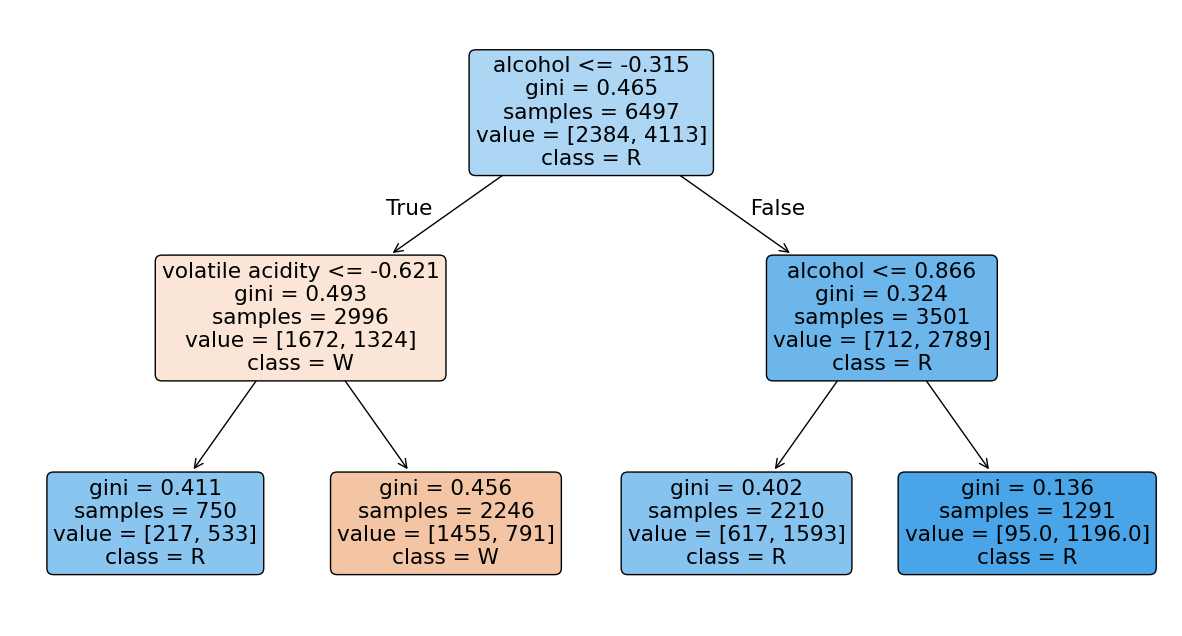

In [77]:
import matplotlib.pyplot as plt
from sklearn import tree

fig = plt.figure(figsize=(15, 8))
_ = tree.plot_tree(
    GridSearch.best_estimator_['clf'],
    feature_names=X.columns,
    class_names=['W', 'R'],
    rounded=True,
    filled=True
)

In [78]:
import pandas as pd

score_df = pd.DataFrame(GridSearch.cv_results_)
score_df[['params', 'rank_test_score', 'mean_test_score', 'std_test_score']]

,params,rank_test_score,mean_test_score,std_test_score
0,{'clf__max_depth': 2},1,0.688800,0.071799
1,{'clf__max_depth': 4},2,0.663565,0.083905
2,{'clf__max_depth': 7},3,0.653408,0.086993
3,{'clf__max_depth': 10},4,0.644016,0.076915
